In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataframe = pd.read_csv("/content/drive/MyDrive/nlp_complaints/complaints.csv")

<ipython-input-4-3d8393b28834>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv("/content/drive/MyDrive/nlp_complaints/complaints.csv")


In [ ]:
whole_data = dataframe[["Product", "Consumer complaint narrative"]][dataframe["Consumer complaint narrative"].notnull()]
whole_data.columns = ["Product", "Complaint"]
whole_data.columns.tolist()

['Product', 'Complaint']

In [ ]:
whole_data["Product"].unique()

array(['Debt collection',
       'Credit reporting or other personal consumer reports',
       'Vehicle loan or lease', 'Credit card', 'Mortgage',
       'Checking or savings account', 'Student loan',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Payday loan, title loan, or personal loan',
       'Money transfer, virtual currency, or money service',
       'Credit card or prepaid card', 'Debt or credit management',
       'Payday loan, title loan, personal loan, or advance loan',
       'Prepaid card', 'Other financial service', 'Consumer Loan',
       'Payday loan', 'Credit reporting', 'Bank account or service',
       'Money transfers', 'Virtual currency'], dtype=object)

In [ ]:
whole_data.count()

Product      1566999
Complaint    1566999
dtype: int64

In [ ]:
number_of_datapoints = 25000
data = whole_data.sample(number_of_datapoints, random_state=1).copy()

In [ ]:
data.replace({'Product':
    {
        'Credit reporting': 'Credit reporting, credit repair services, or other personal consumer reports',
        'Credit reporting, repair, or other': 'Credit reporting, credit repair services, or other personal consumer reports',
        'Credit reporting or other personal consumer reports': 'Credit reporting, credit repair services, or other personal consumer reports',
        'Credit card': 'Credit card or prepaid card',
        'Prepaid card': 'Credit card or prepaid card',
        'Payday loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Payday loan, title loan, or personal loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Money transfers': 'Money transfer, virtual currency, or money service',
        'Virtual currency': 'Money transfer, virtual currency, or money service',
        'Bank account or service': 'Money transfer, virtual currency, or money service',
        'Debt or credit management': 'Credit reporting, credit repair services, or other personal consumer reports',
        'Consumer Loan': 'Credit reporting, credit repair services, or other personal consumer reports'}},
    inplace=True)

In [ ]:
data["Product"].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    14175
Debt collection                                                                  3605
Credit card or prepaid card                                                      2089
Mortgage                                                                         1699
Checking or savings account                                                      1253
Money transfer, virtual currency, or money service                                846
Student loan                                                                      584
Vehicle loan or lease                                                             434
Payday loan, title loan, personal loan, or advance loan                           313
Other financial service                                                             2
Name: Product, dtype: int64

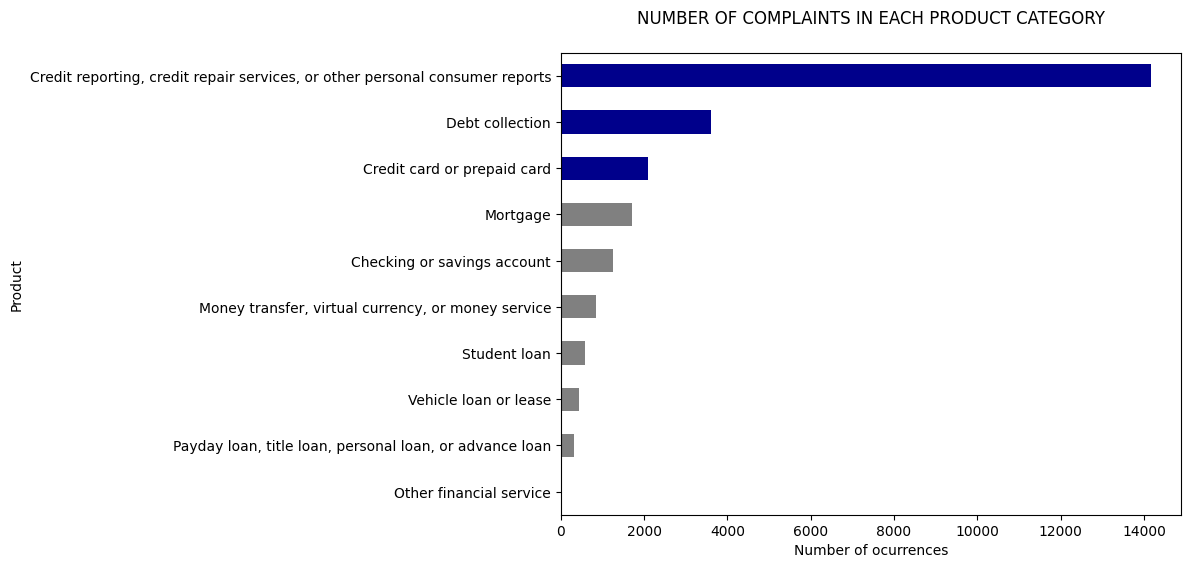

In [ ]:
fig = plt.figure(figsize=(8, 6))
colors = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey',
          'grey', 'darkblue', 'darkblue', 'darkblue']
data.groupby('Product').Complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title='NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize=10);

In [ ]:
# Create a new column 'category_id' with encoded categories
data['category_id'] = data['Product'].factorize()[0]
category_id_df = data[['Product', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
data.head()

,Product,Complaint,category_id
900708,"Credit reporting, credit repair services, or o...",XXXX has been non-compliant with removing the ...,0
2498665,Debt collection,Ordered a guitar online from XXXX XXXX ( XXXX ...,1
170610,"Credit reporting, credit repair services, or o...",Between XXXX and XXXX my car loan payments wer...,0
357502,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX The Supervisor at Transunion XX...,0
2238714,Debt collection,Received collections letters & phone calls fro...,1


The following code is based on [this](https://github.com/PradipNichite/Youtube-Tutorials/blob/main/FineTune_BERT_Model_Youtube.ipynb) code.

In [ ]:
X = data['Complaint']  # Collection of documents
y = data['category_id']  # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.25,
                                                  random_state=20)

In [ ]:
EPOCHS = 2
BATCH_SIZE = 8
NUM_CLASSES = len(category_to_id)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model = model.to('cuda')

In [ ]:
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val.tolist(), padding=True, truncation=True, max_length=512)

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train.tolist())
val_dataset = Dataset(X_val_tokenized, y_val.tolist())

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.899100
1000,0.628100
1500,0.565900
2000,0.549800
2500,0.493900
3000,0.391000
3500,0.413800
4000,0.398200
4500,0.361100


TrainOutput(global_step=4688, training_loss=0.5160646552518773, metrics={'train_runtime': 1330.0896, 'train_samples_per_second': 28.194, 'train_steps_per_second': 3.525, 'total_flos': 9867373286400000.0, 'train_loss': 0.5160646552518773, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5098720192909241,
 'eval_accuracy': 0.85648,
 'eval_precision': 0.7343480242766067,
 'eval_recall': 0.715847373112689,
 'eval_f1': 0.7226992470832442,
 'eval_runtime': 64.2003,
 'eval_samples_per_second': 97.352,
 'eval_steps_per_second': 12.181,
 'epoch': 2.0}